In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ashiskumarpal","key":"0046f848111013df84d218a50fac733d"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s dogbreedidfromcomp 

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1395          5  0.1764706        


In [5]:
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 98% 676M/691M [00:03<00:00, 167MB/s]
100% 691M/691M [00:03<00:00, 219MB/s]
/content


In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Archive:  dog_dataset/dogbreedidfromcomp.zip
replace dog_dataset/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: dog_dataset/sample_submission.csv  
replace dog_dataset/test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [9]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
breeds_all = labels_all["breed"]
breeds_count = breeds_all.value_counts()
breeds_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [16]:
CLASS_NAMES = ['boston_bull', 'afghan_hound', 'scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
3,38,010d65bd29d246aea53d9849da142ccf,boston_bull
4,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound


In [17]:
X_data = np.zeros((len(labels),224,224,3), dtype = 'float32')
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'] [i] , target_size=(224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(),axis=0)
  X_data[i] = x/255.0


100%|██████████| 560/560 [00:02<00:00, 235.47it/s]


In [18]:
print ('\ nTrain Images shape:', X_data.shape, 'size: {:,}'. format (X_data.size))
print ('One-hot encoded output shape:', Y_data.shape, 'size: {:,}'. format (Y_data.size))

\ nTrain Images shape: (560, 224, 224, 3) size: 84,295,680
One-hot encoded output shape: (560, 5) size: 2,800


In [ ]:
print ('\ nTrain Images shape:', X_data.shape, 'size: {:,}'. format (X_data.size))
print ('One-hot encoded output shape:', Y_data.shape, 'size: {:,}'. format (Y_data.size))

\ nTrain Images shape: (357, 224, 224, 3) size: 53,738,496
One-hot encoded output shape: (357, 3) size: 1,071


In [19]:
model = Sequential ()

model.add (Conv2D (filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add (MaxPool2D (pool_size = (2,2)))

model.add (Conv2D (filters = 32, kernel_size = (3,3), activation = 'relu', kernel_regularizer = 'l2'))
model.add (MaxPool2D (pool_size = (2,2)))

model.add (Conv2D (filters = 16, kernel_size = (7,7), activation = 'relu', kernel_regularizer = 'l2'))
model.add (MaxPool2D (pool_size = (2,2)))

model.add (Conv2D (filters = 8, kernel_size = (5,5), activation = 'relu', kernel_regularizer = 'l2'))
model.add (MaxPool2D (pool_size = (2,2)))

model.add (Flatten ())
model.add (Dense (128, activation = "relu", kernel_regularizer = 'l2'))
model.add (Dense (64, activation = "relu", kernel_regularizer = 'l2'))
model.add (Dense (len (CLASS_NAMES), activation = "softmax"))
model.compile (loss = 'categorical_crossentropy', optimizer = Adam (0.0001), metrics = ['accuracy'])
model.summary ()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [20]:
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split (X_data, Y_data, test_size = 0.1)
X_train, X_val, Y_train, Y_val = train_test_split (X_train_and_val, Y_train_and_val, test_size = 0.2)


Epoch 1/100
4/4 [==============================] - 52s 11s/step - loss: 5.3984 - accuracy: 0.2208 - val_loss: 5.3772 - val_accuracy: 0.2574
Epoch 2/100
4/4 [==============================] - 46s 11s/step - loss: 5.3469 - accuracy: 0.2407 - val_loss: 5.3329 - val_accuracy: 0.2871
Epoch 3/100
4/4 [==============================] - 46s 11s/step - loss: 5.2997 - accuracy: 0.2581 - val_loss: 5.2911 - val_accuracy: 0.3465
Epoch 4/100
4/4 [==============================] - 46s 11s/step - loss: 5.2516 - accuracy: 0.3077 - val_loss: 5.2538 - val_accuracy: 0.3069
Epoch 5/100
4/4 [==============================] - 46s 11s/step - loss: 5.2043 - accuracy: 0.3176 - val_loss: 5.2164 - val_accuracy: 0.3267
Epoch 6/100
4/4 [==============================] - 47s 11s/step - loss: 5.1577 - accuracy: 0.3300 - val_loss: 5.1791 - val_accuracy: 0.2871
Epoch 7/100
4/4 [==============================] - 46s 11s/step - loss: 5.1121 - accuracy: 0.3300 - val_loss: 5.1398 - val_accuracy: 0.2871
Epoch 8/100
4/4 [===

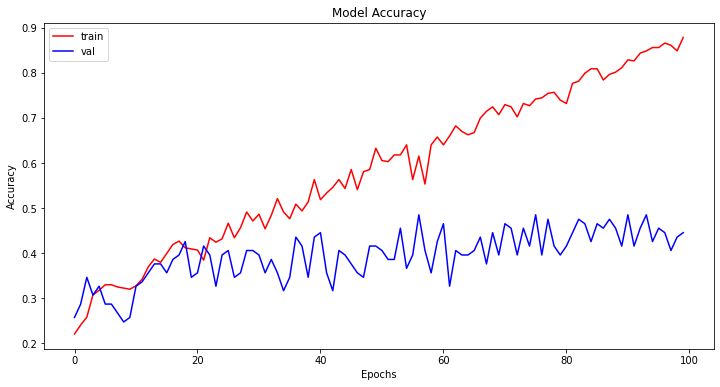

In [21]:
epochs = 100
batch_size = 128
history = model.fit (X_train, Y_train, batch_size = batch_size, epochs = epochs,validation_data = (X_val, Y_val))

plt.figure (figsize = (12, 6))
plt.plot (history.history ['accuracy'], color = 'r')
plt.plot (history.history ['val_accuracy'], color = 'b')
plt.title ('Model Accuracy')
plt.ylabel ('Accuracy')
plt.xlabel ('Epochs')
plt.legend (['train', 'val'])
plt.show ()



In [22]:
Y_pred = model.predict (X_test)
score = model.evaluate (X_test, Y_test)
print ('Accuracy over the test set: \ n', round ((score [1] * 100), 2), '%')


2/2 [==============================] - 3s 1s/step - loss: 3.7075 - accuracy: 0.5179
Accuracy over the test set: \ n 51.79 %


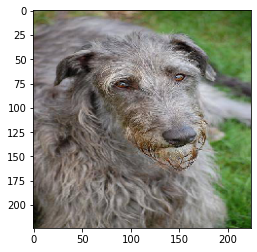

In [23]:
plt.imshow (X_test [1,:,:,:])
plt.show ()


In [24]:
print ("Originally:", labels ['breed'] [np.argmax (Y_test [1])])
print ("Predicted:", labels ['breed'] [np.argmax (Y_pred [1])])


Originally: maltese_dog
Predicted: boston_bull
